In [1]:
import os
import orbitize
from orbitize import driver
import matplotlib.pyplot as plt
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from datetime import datetime
from astropy.time import Time
# sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

In [2]:
import pandas as pd
import numpy as np

In [3]:
results = pd.read_csv(
    'thesis_allast.csv',
    header = 0,
    sep = ','
)

In [4]:
import datetime
results['datetime'] = [datetime.datetime.strptime(x, '%Y/%m/%d') for x in results['Date (year/month/day)']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.ones(len(results), dtype=np.int8)
outtable['sep'] = results['Sep (mas)']
outtable['sep_err'] = results['Sep_err']
outtable['pa'] = results['PA (deg)']
outtable['pa_err'] = results['PA_err']
outtable['instrument'] = results['Instrument']
outtable.to_csv('hd142-allast-orbitizelike.csv', index=False)
outtable['source'] = results['Source']
outtable['wavelength'] = results['Wavelength']
outtable['method'] = results['Method']
outtable.to_csv('hd142-allast-full.csv', index=False)

In [ ]:
filename = "hd142-allast-orbitizelike_wrvs.csv"

from orbitize import read_input, system, priors, sampler, driver, DATADIR, hipparcos, gaia
# The Hipparcos ID of your target. Available on Simbad.
hip_num = '078092'

# Name/path for the plot this function will make
saveplot = 'HD142527_IADrefit.png'

# Location of the Hipparcos IAD file.
IAD_file = '{}H{}.d'.format(os.getcwd()+'/', hip_num)

### ACTUAL ORBITIZE ###

data_table = read_input.read_file(filename)

# system parameters
num_secondary_bodies = 1
hipparcos_number = hip_num
hipparcos_filename = IAD_file

# HIP logprob
HD142527_Hip = hipparcos.HipparcosLogProb(
    hipparcos_filename, hipparcos_number, num_secondary_bodies
)
# gaia logprob
HD142527_edr3_number = 5994826707951507200
HD142527_Gaia = gaia.GaiaLogProb(
    HD142527_edr3_number, HD142527_Hip, dr='edr3'
)

# more system parameters
m0 = 2.05 # [Msol]
plx = 6.35606723729484 # [mas]
fit_secondary_mass = True

mass_err = 0.5 # [Msol]
plx_err = 0.04714455423 # [mas]

HD142527_system = system.System(
    num_secondary_bodies, data_table, m0, plx, hipparcos_IAD=HD142527_Hip,
    gaia=HD142527_Gaia, fit_secondary_mass=fit_secondary_mass, mass_err=mass_err,
    plx_err=plx_err
)

# set uniform primary mass prior
m0_index = HD142527_system.param_idx['m0']
HD142527_system.sys_priors[m0_index] = priors.GaussianPrior(2.05, 0.3)
# set uniform primary mass prior
m1_index = HD142527_system.param_idx['m1']
HD142527_system.sys_priors[m1_index] = priors.GaussianPrior(0.25, 0.2)

# MCMC parameters
num_temps = 20
num_walkers = 50
num_threads = int(mp.cpu_count())

# init driver
HD142527_sampler = sampler.MCMC(
    HD142527_system, num_threads=num_threads, num_temps=num_temps,
    num_walkers=num_walkers
)
print('Driver Initialized! Running MCMC...')

# HD142527_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

myResults = HD142527_sampler.results

# # save posterior to disk
# savefile = 'rel_abs_rvs_posterior.hdf5'
# myResults.save_results(savefile)
# print('Saved Posterior!')

In [6]:
# load in saved hdf5 result
hdf5_filename='rel-only/rel_posterior.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename, 
#                             IADfile=IAD_file, 
                            append=True)

In [7]:
# colors used in previous plot
colors = ['#89adc5', '#5f61b4', '#491564', '#501444', 'xkcd:light orange', '#a54350', '#ca997c', '#e2d9e2']
#'xkcd:light orange' for visao
symbols = ['s','^','D','x','o','v',]

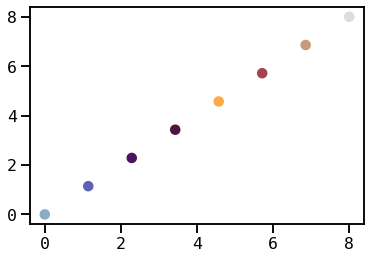

In [8]:
plt.scatter(np.linspace(0,len(colors),len(colors)), np.linspace(0,len(colors),len(colors)), c=colors)

In [9]:
loaded_results.labels

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot']

In [10]:
post = loaded_results.post

In [11]:
import statistics

In [12]:
results = pd.DataFrame(index=range(len(post[0,:])), columns=['med','err1','err2'])
for i in range(len(post[0,:])):    
    mode = np.median(post[:, i])#[0][0]
    percens = np.percentile(post[:, i], [16, 84])
    if i in [2,3,4]:
        from astropy.stats import circmean, circstd
        if i == 2:
            med = np.rad2deg(circmean(post[:,i]))
            errs = np.percentile(post[:,i], [16,84])
        else:
            post1 = post[post[:, i]<np.deg2rad(180)]
            post2 = post[post[:, i]>np.deg2rad(180)]
            med1, errs1 = np.rad2deg(circmean(post1[:, i])) % 360, np.rad2deg(np.percentile(post1[:,i], [16,84])) % 360 - np.rad2deg(circmean(post1[:, i])) % 360#circstd(post1[:, i])) % 360
            med2, errs2 = np.rad2deg(circmean(post2[:, i])) % 360, np.rad2deg(circstd(post2[:, i])) % 360
            med = med1, med2
            errs = errs1#, errs2
    elif i == 5:
        import orbitize.basis
        tau_ref_epoch = loaded_results.tau_ref_epoch#58849
        taucut = post[post[:, 5]<0.5]
        sma = taucut[:, 0]
        mtot = np.median(taucut[:,7])
        period = np.sqrt(sma**3/mtot)
        tau = taucut[:,5]
        tp = orbitize.basis.tau_to_tp(tau,tau_ref_epoch,period)
        mode = np.nanmedian(tp)#[0][0]
        percens = np.percentile(tp, [16, 84])
        mode = Time(mode, format='mjd').decimalyear
        percens = np.array([Time(x, format='mjd').decimalyear for x in percens])
        med, errs = round(mode,2), np.round(percens,2)-round(mode,2)
    else:
        med = round(mode,2)
        errs = np.round(percens,2)-round(mode,2)
    results.iloc[i]['med'] = med
    results.iloc[i]['err1'],results.iloc[i]['err2'] = errs
# results.to_clipboard()

In [13]:
results.index = loaded_results.labels

In [14]:
results

,med,err1,err2
sma1,14.71,-2.33,8.18
ecc1,0.28,-0.1,0.22
inc1,126.265856,2.1254,2.280786
aop1,"(86.0208284073103, 268.60348037726163)",-42.585355,52.311532
pan1,"(131.65760083808937, 312.0464155066282)",-6.122782,5.513715
tau1,2021.07,-0.72,0.82
plx,6.36,-0.05,0.05
mtot,2.49,-0.27,0.27


In [15]:
results.to_clipboard()

<Figure size 1008x432 with 0 Axes>

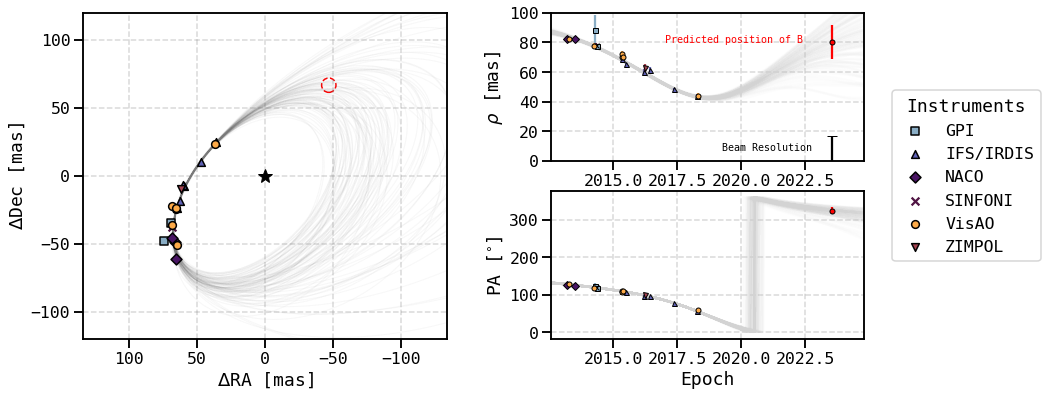

In [97]:
# epochs = outtable['epoch']
orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    num_epochs_to_plot= 500,
    start_mjd=Time(2011., format='decimalyear').mjd, # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=True,
    plot_astrometry_insts=True,
    show_colorbar=False,
    plot_astrometry_insts_leg = ([2.65,.50],'center right'),
    astr_colors=colors,
    astr_symbols=symbols,
    no_cbar = True,
    cbar_param = 'ecc1',
#     plot_best=medparas,
#     data = my_driver.system.data_table,
#     mod180=True
)

ax_orb, ax_sep, ax_pa,  = orb_fig.axes
c = 0


ax_orb.plot(0,0,marker="*",color='black',markersize=15)
# ax_sep.legend()
# ax_pa.legend()

# zoom in a bit
ax_sep.set_xlim(2012.6,2024.8)
ax_pa.set_xlim(2012.6,2024.8)
ax_sep.set_ylim(0,100)
# ax_pa.set_ylim(30,150)

ax_orb.set_xlim(120,-120)
ax_orb.set_ylim(-120,120)

plt.subplots_adjust(
                    wspace=-0.50,
#                     hspace=-0.25
                   )

# pred for alma epoch
# RA Offset = -46.938 +/- 3.623 mas
# Dec Offset = 66.579 +/- 17.077 mas
# Separation = 80.144 +/- 11.597 mas
# PA = 324.565 +/- 10.513 deg
# Planetary RV = 4.505 +/- 8.796 km/s

predra = [-46.938]
preddec = [66.579]
errorrad = np.sqrt((11.597)**2 + (17.077)**2)
predsep = [80.144, 11.597]
predpa = [324.565, 10.513]

ax_orb.scatter(predra, preddec, s=10*errorrad, facecolors='none', edgecolors='r',
            linestyle='--')
preddate = datetime.datetime.strptime('2023/07/20', '%Y/%m/%d')
predepoch = Time(preddate, format='datetime').decimalyear
ax_sep.errorbar(predepoch, predsep[0], yerr=predsep[1], fmt='.', ls='none', mfc='red', mec='k', color='r', markersize=10, zorder=10)
ax_pa.errorbar(predepoch, predpa[0], yerr=predpa[1], fmt='.', ls='none', mfc='red', mec='k', color='r', markersize=10, zorder=10)

ax_sep.errorbar(predepoch, 7, yerr=10, fmt='', ls='none', mfc='k', mec='k', color='k', markersize=10, capsize=5, zorder=10)

ax_sep.text(predepoch-4.3, 7, 'Beam Resolution', fontsize=10)
ax_sep.text(predepoch-6.5, 80, 'Predicted position of B', fontsize=10, color='r')

ax_sep.yaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
ax_sep.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
ax_pa.yaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
ax_pa.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
ax_orb.yaxis.grid(color='gray', linestyle='dashed', alpha=0.3)
ax_orb.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)

# plt.show()
plt.savefig('HD142527_B_almaprediction.jpg', dpi=300, bbox_inches='tight') # This is matplotlib.figure.Figure.savefig()

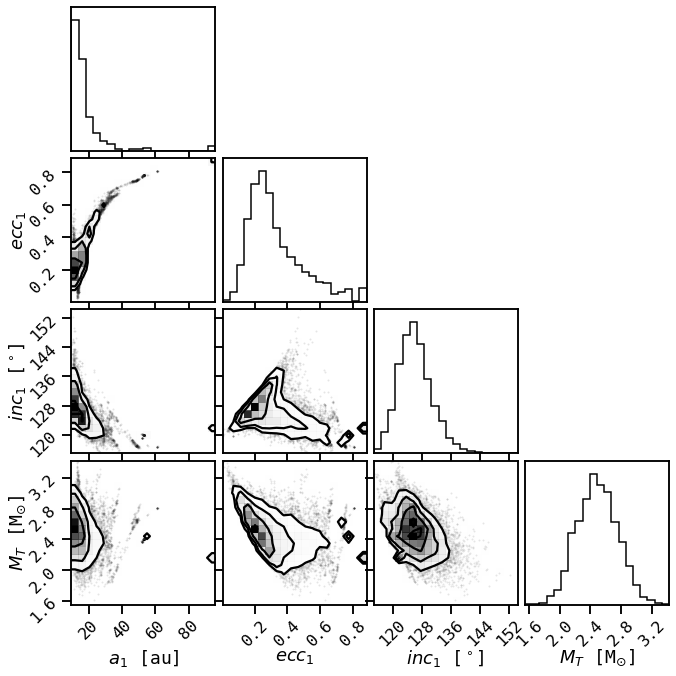

In [41]:
corny = loaded_results.plot_corner(param_list=['sma1','ecc1','inc1','mtot',])#, smooth=0.5)

In [98]:
import pandas as pd
params = [r'i$_\star$', r'$\Omega_\star$', r'i$_{disk, inner}$', r'$\Omega_{disk, inner}$', r'i$_{disk, outer}$', r'$\Omega_{disk, outer}$', r'$\theta_{in-\star}$', r'$\theta_{\star-out}$']
mutinc = pd.DataFrame(columns=params)
mutinc[r'i$_\star$'] = post[:,2]
mutinc[r'$\Omega_\star$'] = post[:,4]

In [99]:
import scipy.stats as scistats

In [100]:
# best estimates
# bohn 2021

#inner disk, gravity
#23.76+2.70−3.18 
#15.44+7.44−6.52 

i_in = [23.76] 
i_in_err = [3.18]

o_in = [15.44] 
o_in_err = [7.44]

i_in_mu = np.array(i_in) 
i_in_sigma = np.array(i_in_err)/i_in_mu

i_in_mu = np.deg2rad(i_in_mu)
i_in_sigma = i_in_sigma*i_in_mu

o_in_mu = np.array(o_in)
o_in_sigma = np.array(o_in_err)/o_in_mu

o_in_mu = np.deg2rad(o_in_mu)
o_in_sigma = o_in_sigma*o_in_mu

#outer disk, alma
#38.21+1.38−1.25
#162.72+1.38−1.25

i_out = [38.21] 
i_out_err = [1.38]

o_out = [162.72]
o_out_err = [1.38]


i_out_mu = np.array(i_out) 
i_out_sigma = np.array(i_out_err)/i_out_mu

i_out_mu = np.deg2rad(i_out_mu)
i_out_sigma = i_out_sigma*i_out_mu

o_out_mu = np.array(o_out)
o_out_sigma = np.array(o_out_err)/o_out_mu

o_out_mu = np.deg2rad(o_out_mu)
o_out_sigma = o_out_sigma*o_out_mu

sets = {r'i$_{disk, inner}$':[i_in, i_in_sigma],
        r'$\Omega_{disk, inner}$':[o_in, o_in_sigma], 
        r'i$_{disk, outer}$':[i_out, i_out_sigma], 
        r'$\Omega_{disk, outer}$':[o_out, o_out_sigma]}

for key in sets.keys():
    paramset = sets[key]
    # Set-up.
    n = len(post[:, 2])
    # Parameters of the mixture components
    norm_params = np.array(paramset).T
    n_components = norm_params.shape[0]
    # Weight of each component, in this case all of them are 1/2
    weights = np.ones(n_components, dtype=np.float64) / n_components
    # A stream of indices from which to choose the component
    mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
    # y is the mixture sample
    y = np.fromiter((scistats.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                       dtype=np.float64)
    
    mutinc[key] = np.deg2rad(y)
    i += 1

In [101]:
# mutual incl formula

def mutualInc(Id, Ib, Omd, Omb, verb=False):
    cosD = (np.cos(Id)*np.cos(Ib))+(np.sin(Id)*np.sin(Ib)*np.cos(Omd-Omb))
    D = np.arccos(cosD)
    if verb is True:
        print('disk-binary mutual inclination is: '+str(D))
    return D % np.pi/2

In [102]:
mutinc[r'$\theta_{in-\star}$'] = mutualInc(mutinc[r'i$_{disk, inner}$'], mutinc[r'i$_\star$'], mutinc[r'$\Omega_{disk, inner}$'],mutinc[r'$\Omega_\star$'])
mutinc[r'$\theta_{\star-out}$'] = mutualInc(mutinc[r'i$_{disk, outer}$'], mutinc[r'i$_\star$'], mutinc[r'$\Omega_{disk, outer}$'],mutinc[r'$\Omega_\star$'])

In [104]:
mutinc = np.rad2deg(mutinc)

In [125]:
print(np.percentile(mutinc[mutinc['$\\Omega_\\star$']>270]['$\\theta_{\\star-out}$'], [16,84])-np.median(mutinc[mutinc['$\\Omega_\\star$']>270]['$\\theta_{\\star-out}$']))

[-2.71662798  2.65599313]


In [115]:
mutinc[mutinc['$\\Omega_\\star$']>270]['$\\theta_{\\star-out}$']

1       77.705249
3       74.901099
14      73.362821
17      77.856199
20      73.128874
          ...    
9989    76.326132
9991    81.043985
9992    81.754940
9994    74.281079
9997    71.616220
Name: $\theta_{\star-out}$, Length: 5174, dtype: float64

In [112]:
mutinc['$\\theta_{in-\\star}$']

0       64.308246
1       56.192715
2       67.674533
3       55.323584
4       67.144997
          ...    
9995    70.487763
9996    67.857285
9997    55.327518
9998    66.475258
9999    63.108436
Name: $\theta_{in-\star}$, Length: 10000, dtype: float64

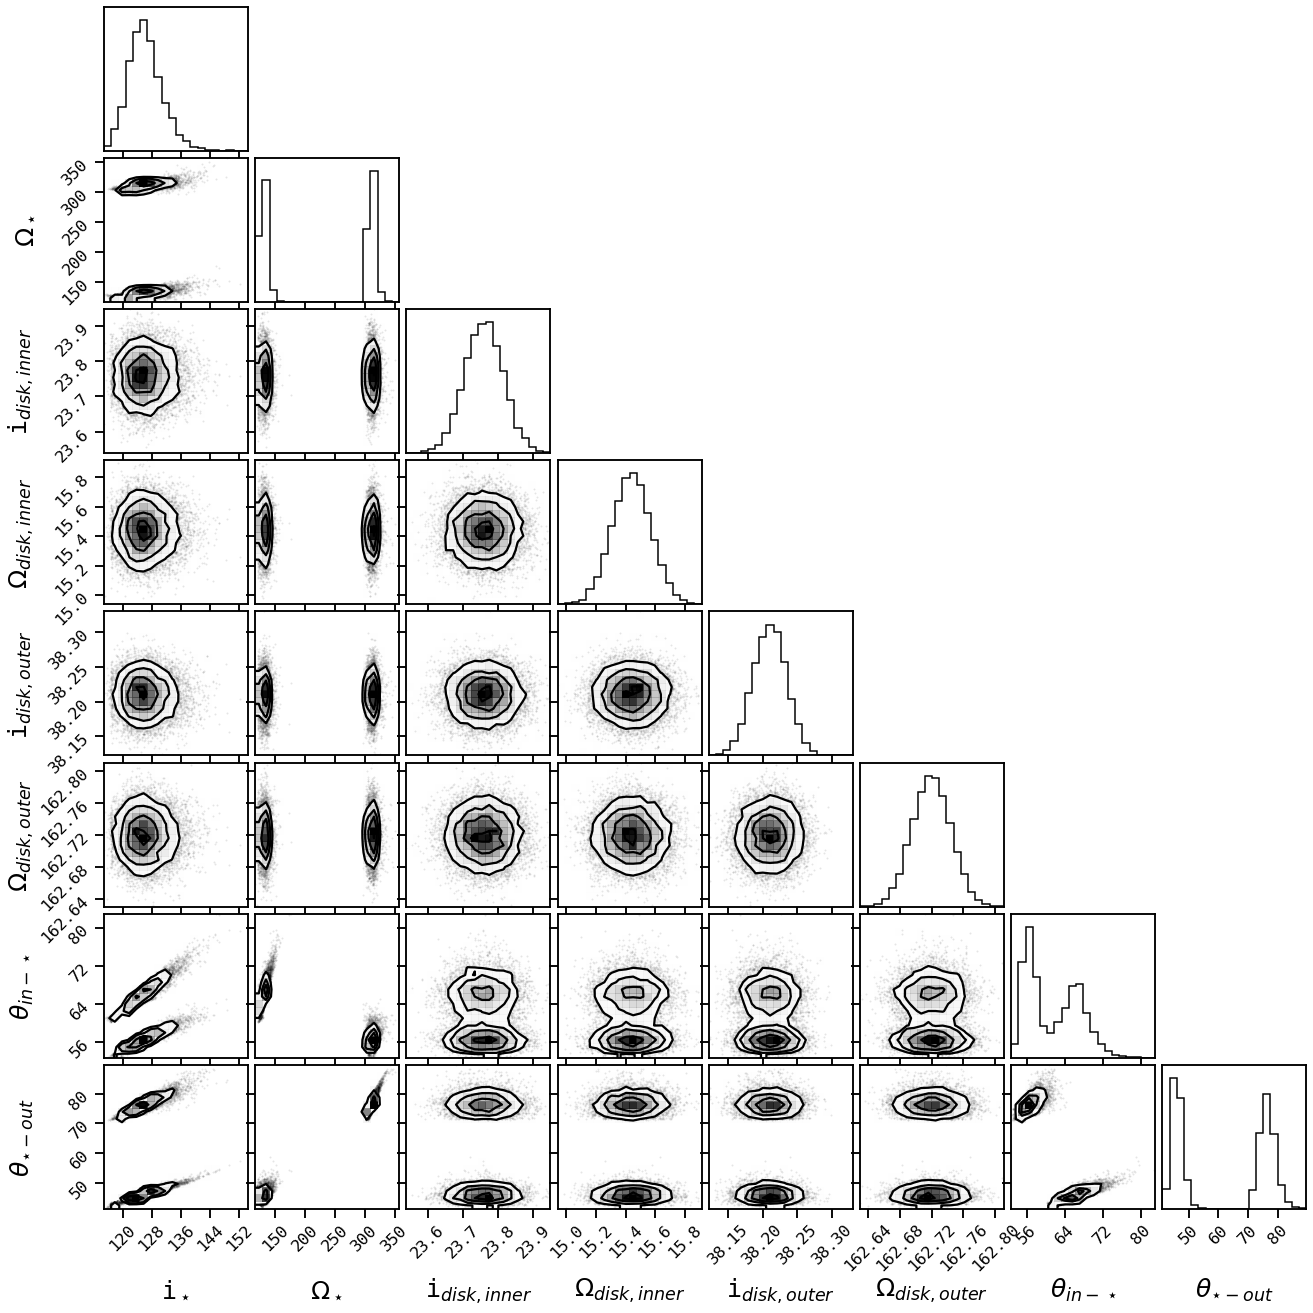

In [109]:
import corner
corny_incs = corner.corner(mutinc, labels=mutinc.columns, labelpad=0.17, label_kwargs={'fontsize':25})
plt.savefig('rel-only/disk_mutual_inc_corner.pdf', rasterize=False, dpi=750, bbox_inches='tight')